Oscars - EECS 731

Taking an older project and revamping it with some cool visualizations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Data Into initial frame
shakes = pd.read_csv("../data/raw/Shakespeare_data.csv")

In [3]:
# Trim off any entries where there is no player, since we don't
# really need this information in a player classification problem

shakes_t = shakes[pd.notnull(shakes['Player'])]
shakes_t = shakes_t.reset_index(drop = True)
shakes_t['ActSceneLine'] = shakes_t['ActSceneLine'].astype(str)
del shakes_t['Dataline']

Lst time around, I looked at the "Chattiest Players" in the plays using a simple bar graph. This time, I will experiement with Seaborn to see if I can make this look any nicer!

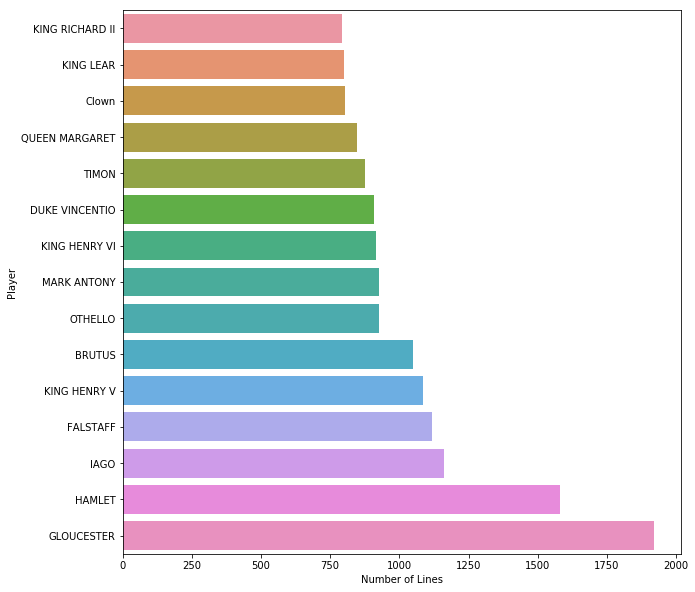

In [4]:
import seaborn as sns
chattiestPlayers = shakes_t['Player'].value_counts()
g = chattiestPlayers.sort_values().tail(15).to_frame()
g['Play'] = g.index.tolist()
g
plt.figure(figsize=(10,10))
ax = sns.barplot(x='Player', y='Play',data=g)
ax.set(xlabel='Number of Lines', ylabel='Player')
plt.show()

The gradient bar graph looks pretty nice for this one! 

I saw a really nice sentiment analysis graph on another notebook, so I decided to bring that graph over here. I think that using sentiment analysis on the lines used is a good way to extract some meaning about each of the players and their polarity of sentiment. This can give us an idea of which players are more volatile

In [5]:
from textblob import TextBlob
data = pd.read_csv('../data/raw/Shakespeare_data.csv')

In [6]:
sentiment = pd.DataFrame(columns=('PlayerLinenumber', 'Player', 'PlayerLine'))
sentiment['PlayerLinenumber'] = data['PlayerLinenumber']
sentiment['Player'] = data['Player']
sentiment['PlayerLine'] = data['PlayerLine']
# Drop nulls
sentiment.dropna()
sent2 = sentiment.groupby(['Player'])['PlayerLine'].apply(list)
sent2 = pd.DataFrame(sent2)
# Get the text sentiment of each character
pol = []
for i in sent2['PlayerLine']:
    txt = TextBlob(str.join(' ', i))
    pol.append( (txt.sentiment.polarity)*10 )
# Temporary dataframe then actual dataframe
character_polarity = pd.DataFrame(sent2.index)
character_polarity = pd.DataFrame({'Player':sent2.index, 'Sentiment':pol})

In [7]:
chars_by_polarity = character_polarity.sort_values(by='Sentiment',ascending=False)

/Users/patrickcanny/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/patrickcanny/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


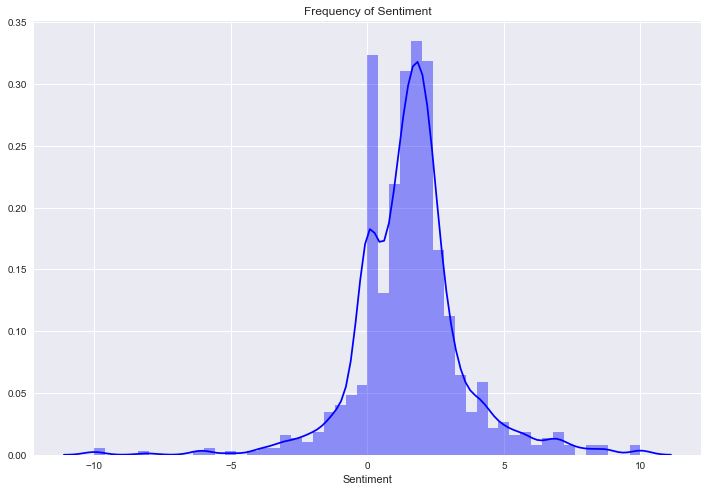

In [8]:
sns.set()
f, axes = plt.subplots(figsize=(10, 7))
sns.distplot(character_polarity['Sentiment'], color="b")
plt.title('Frequency of Sentiment')
plt.tight_layout()

By this graph, it seems that most lines in Shakespeare are fairly neutral.

Higher numbers in either direction represent either hihgly positive or highly negative remarks, respectively. The idea that most sentiments are slightly positive may indicate that the sentiment analysis either has some difficulty with older language, or that truly most players are positive.

In [9]:
# I used a label encoder to enumerate all the values seen
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(shakes_t['Player'])
shakes_t['Player'] = le.transform(shakes_t['Player'])

In [10]:
le.fit(shakes_t['ActSceneLine'])
shakes_t['ActSceneLine'] = le.transform(shakes_t['ActSceneLine'])

In [11]:
le.fit(shakes_t['Play'])
shakes_t['Play'] = le.transform(shakes_t['Play'])
shakes_t.head(10)

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,9,1.0,324,457,"So shaken as we are, so wan with care,"
1,9,1.0,435,457,"Find we a time for frighted peace to pant,"
2,9,1.0,546,457,And breathe short-winded accents of new broils
3,9,1.0,657,457,To be commenced in strands afar remote.
4,9,1.0,768,457,No more the thirsty entrance of this soil
5,9,1.0,781,457,Shall daub her lips with her own children's bl...
6,9,1.0,792,457,"Nor more shall trenching war channel her fields,"
7,9,1.0,803,457,Nor bruise her flowerets with the armed hoofs
8,9,1.0,814,457,"Of hostile paces: those opposed eyes,"
9,9,1.0,325,457,"Which, like the meteors of a troubled heaven,"


In [12]:
# Take random samples from the dataset using 'sample' and preserve
# state with 'random_state'
# Unfortunately, I don't believe that this is a partition.
training = shakes_t.sample(frac=0.8, random_state=1)
testing = shakes_t.sample(frac=0.1, random_state=1)
validation = shakes_t.sample(frac=0.1, random_state=1)

In [13]:
# Refactor dataframes so that the decision, Player, is the final col
training = training[['Play', 'PlayerLinenumber', 'ActSceneLine', 'Player']]
testing = testing[['Play', 'PlayerLinenumber', 'ActSceneLine', 'Player']]
validation = validation[['Play', 'PlayerLinenumber', 'ActSceneLine', 'Player']]

# Save new dataframes
training.to_csv('../data/processed/training.csv', compression='gzip')
testing.to_csv('../data/processed/testing.csv', compression='gzip')
validation.to_csv('../data/processed/validation.csv', compression='gzip')

Next, I wanted to start building out some sort of classification model. I figured that Random Forests would be a good place to start given its high accclaim from some of my colleagues and Martin. 

In [14]:
# Set Up Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier

/Users/patrickcanny/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [15]:
# Next, establish decision.
D = training['Player']

In [16]:
# Features are every other meaningful column
features = ['Play', 'PlayerLinenumber', 'ActSceneLine']
features

['Play', 'PlayerLinenumber', 'ActSceneLine']

At this point, it is probably best to test out the classifier by training it on the training set. From there, we should be able to predict the player on the training and validation sets.

In [ ]:
training = training.drop('Player', 1)
clf = RandomForestClassifier(n_jobs=2, random_state=0)
initialFit = clf.fit(training, D)

In [ ]:
# Show feature importance
feats = {} 
for feature, importance in zip(training.columns, clf.feature_importances_):
    feats[feature] = importance 
print(feats)

In [ ]:
testing.head(7)

In [ ]:
# Now test it on another partition
from sklearn.metrics import accuracy_score
T = testing['Player']
testing = testing.drop('Player', 1)
predicted = clf.predict(testing)
print(accuracy_score(T, predicted))

Seems pretty good! 

In [ ]:
# Some sanity checks since I thought that this model was a little too good to be true
testing.head(10)

In [ ]:
T

In [ ]:
# Finally, look at validation set in the same way.
V = validation['Player']
validation = validation.drop('Player', 1)
predictedV = clf.predict(validation)
print(accuracy_score(V, predictedV))